# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# ------ imports -----
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import time
import datetime
import json

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from collections import OrderedDict
# --------------------

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# -------------------------------------------------------------------
# ----------------------- train -------------------------------------
# -------------------------------------------------------------------

# ---- set parameters ---------------
param_data_directory = "flowers"            # default: flowers
param_output_size = 102                     # 102 - original # 10 - test
param_save_file_name = "checkpoint.pth"     # checkpoint.pth
param_save_directory = "./"                 # ./
param_architecture = "vgg13"                # densenet121 or vgg13 or resnet18
param_learning_rate = 0.001                 # 0.001
param_hidden_units = 500                    # 500
param_epochs = 3                            # 3
param_gpu = True                            # True or False
# -----------------------------------

print("----- running with params -----")
print("data directory: ", param_data_directory)
print("save directory: ", param_save_directory)
print("architecture:   ", param_architecture)
print("learning rate:  ", param_learning_rate)
print("hidden units:   ", param_hidden_units)
print("epochs:         ", param_epochs)
print("gpu:            ", param_gpu)
print("-------------------------------")

# ------- create cnn model -------
print("cnn neural network ...")
print("  load image data ... ", end="")
# define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder( param_data_directory + '/train', transform=train_transforms )
test_data = datasets.ImageFolder( param_data_directory + '/test', transform=test_transforms )
valid_data = datasets.ImageFolder( param_data_directory + '/valid', transform=test_transforms )

trainloader = torch.utils.data.DataLoader( train_data, batch_size=32, shuffle=True )
testloader = torch.utils.data.DataLoader( test_data, batch_size=16 )
validloader = torch.utils.data.DataLoader( valid_data, batch_size=16 )
print("done")

class_to_idx = test_data.class_to_idx

----- running with params -----
data directory:  flowers
save directory:  ./
architecture:    vgg13
learning rate:   0.001
hidden units:    500
epochs:          3
gpu:             True
-------------------------------
cnn neural network ...
  load image data ... done


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [3]:
# ------ load dictionary -----------
print("load data dictionary ... ", end="")
with open("cat_to_name.json", 'r') as f:
    cat_to_name = json.load(f)
print("done")
# ----------------------------------

load data dictionary ... done


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [4]:
# -------------------------------------------------------------------
# -------------------------------------------------------------------

def do_deep_learning(model, trainloader, validloader, optimizer, criterion, epochs, print_every, is_gpu):
    ''' train the model based on the train-files '''
    if is_gpu:
        print("start deep-learning in -gpu- mode ... ")
    else:
        print("start deep-learning in -cpu- mode ... ")
    
    epochs = epochs
    print_every = print_every
    steps = 0

    # change to cuda in case it is activated
    if is_gpu:
        model.cuda()

    model.train() # ---------- put model in training mode -------------------
    
    for e in range(0, epochs):
        running_loss = 0
        for ii, (images, labels) in enumerate( trainloader ):
            steps += 1

            if is_gpu:
                images, labels = images.cuda(), labels.cuda()
            
            images, labels = Variable(images), Variable(labels)

            optimizer.zero_grad()

            # forward and backward passes
            outputs = model( images )
            loss = criterion( outputs, labels )
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # ----- output ----
            if steps % print_every == 0:
                # make sure network is in eval mode for inference
                model.eval() # ------------- put model in evaluation mode ----------------
                
                # turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    test_loss, accuracy = validation( model, validloader, criterion, is_gpu )
                    
                print("epoch: {}/{}.. ".format( e+1, epochs ),
                      "training loss: {:.3f}.. ".format( running_loss / print_every ),
                      "validation loss: {:.3f}.. ".format( test_loss / len(validloader) ),
                      "validation accuracy: {:.3f}".format( accuracy / len(validloader) ))
                
                running_loss = 0
                
                # make sure training is back on
                model.train() # ---------- put model in training mode -------------------
            # ----------------- 
    print("-- done --")


# implement a function for the validation pass
def validation(model, validloader, criterion, is_gpu):
    ''' calculate the validation based on the valid-files and return the test-loss and the accuracy '''
    test_loss = 0
    accuracy = 0
    
    # change to cuda in case it is activated
    if is_gpu:
        model.cuda()
        
    for images, labels in validloader:
        if is_gpu:
            images, labels = images.cuda(), labels.cuda()
                
        output = model( images )
        test_loss += criterion( output, labels ).item()

        ps = torch.exp( output )
        equality = ( labels.data == ps.max(dim=1)[1] ) # give the highest probability
        accuracy += equality.type( torch.FloatTensor ).mean()
    
    return test_loss, accuracy
    


def check_accuracy_on_test(model, testloader, is_gpu):
    ''' calculate the accuracy based on the test-files and print it out in percent '''
    print("calculate accuracy on test ... ", end="")
    correct = 0
    total = 0
    
    # change to cuda in case it is activated
    if is_gpu:
        model.cuda()
    
    model.eval() # ------------- put model in evaluation mode ----------------
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            if is_gpu:
                images, labels = images.cuda(), labels.cuda()
                    
            outputs = model( images )
            _, predicted = torch.max( outputs.data, 1 )
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print("done.")
    print('accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


def save_model(model, optimizer, filename, data_directory, class_to_idx, architecture, in_features, hidden_units, output_size, epochs, learning_rate):
    ''' save the trained model in a file '''
    print("save model to: ", filename, end="")
    checkpoint = {'arch': architecture,
                  'in_features': in_features,
                  'hidden_units': hidden_units,
                  'learning_rate': learning_rate,
                  'output_size': output_size,
                  'data_directory': data_directory,
                  'epochs': epochs,
                  'optimizer_state_dict': optimizer.state_dict,
                  'class_to_idx': class_to_idx,
                  'state_dict': model.state_dict()}
    torch.save(checkpoint, filename)
    print(" ... done")



def get_in_features_from_model_architecture(model, param_architecure):
    ''' return the correct in-features for the classifier and the first layer 
        based on the choosen architecture 
    '''
    in_features = 0
    
    if "vgg" in param_architecure:
        in_features = model.classifier[0].in_features
    elif "densenet" in param_architecure:
        in_features = model.classifier.in_features
    elif "resnet" in param_architecure:
        in_features = model.fc.in_features
    
    return in_features
    
    
# -------------------------------------------------------------------
# -------------- helper functions -----------------------------------
# -------------------------------------------------------------------
def get_duration_in_time(duration):
    ''' calculate the duration in hh::mm::ss and return it '''
    seconds = int( duration % 60 )
    minutes = int( (duration / 60) % 60 )
    hours   = int( (duration / 3600) % 24 )
    output = "{:0>2}:{:0>2}:{:0>2}".format(hours, minutes, seconds)
    return output
    


def get_current_date_time():
    ''' return the current date and time '''
    utc_dt = datetime.datetime.now(datetime.timezone.utc) # UTC time
    dt = utc_dt.astimezone() # local time
    return str(dt)
 


def load_model( filename, is_gpu ):
    ''' load the trained model from the file and create a model from this and return it '''
    print("load model from: ", filename)
    checkpoint = torch.load(filename)
    
    print("create model ... ", end="")
    model = models.__dict__[checkpoint['arch']](pretrained=True)
    
    # this is needed for pre-trained networks
    # freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    
    classifier = nn.Sequential(OrderedDict([
                              ('do1', nn.Dropout()),
                              ('fc1', nn.Linear(checkpoint['in_features'], checkpoint['hidden_units'])),
                              ('relu', nn.ReLU()),
                              ('do2', nn.Dropout()),
                              ('fc2', nn.Linear(checkpoint['hidden_units'], checkpoint['output_size'])),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
    
    model.classifier = classifier
    
    if is_gpu and torch.cuda.device_count() > 1:
        print("let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
        
    print("done")
    print("initialize model ... ", end="")
    model.load_state_dict(checkpoint['state_dict'])
    print("done")
    
    class_to_idx = checkpoint['class_to_idx']
    
    return model, class_to_idx


def plot_bargraph( np_probs, np_flower_names ):
    ''' plot an bar graph '''
    y_pos = np.arange( len(np_flower_names) )
    
    plt.barh(y_pos, np_probs, align='center', alpha=0.5)
    plt.yticks(y_pos, np_flower_names)
    plt.gca().invert_yaxis()        # invert y-axis to show the highest prob at the top position
    plt.xlabel("probability from 0 to 1.0")
    plt.title("flowers")
    plt.show()

    
# ------------------------------------
print("create model ... ", end="")
model = models.__dict__[param_architecture](pretrained=True) 

# get the correct in-features for the classifier and the first layer
in_features = get_in_features_from_model_architecture(model, param_architecture )

# this is needed for pre-trained networks
# freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('do1', nn.Dropout()),
                          ('fc1', nn.Linear(in_features, param_hidden_units)),
                          ('relu', nn.ReLU()),
                          ('do2', nn.Dropout()),
                          ('fc2', nn.Linear(param_hidden_units, param_output_size)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier

# train a model with a pre-trained network
criterion = nn.NLLLoss()
optimizer = optim.Adam( model.classifier.parameters(), lr=param_learning_rate )
print("done")

if param_gpu and torch.cuda.device_count() > 1:
    print("let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

print("initialized.")
# --------------------------------

# save time stamp
start_time = time.time()
# --------- training --------
do_deep_learning( model, trainloader, validloader, optimizer, criterion, param_epochs, 20, param_gpu )
# ---------------------------
# print duration time
print("duration: ", get_duration_in_time( time.time() - start_time ) )

create model ... 

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.torch/models/vgg13-c768596a.pth
100%|██████████| 532194478/532194478 [00:22<00:00, 23356958.29it/s]


done
initialized.
start deep-learning in -gpu- mode ... 
epoch: 1/3..  training loss: 4.818..  validation loss: 3.965..  validation accuracy: 0.174
epoch: 1/3..  training loss: 4.052..  validation loss: 3.374..  validation accuracy: 0.306
epoch: 1/3..  training loss: 3.681..  validation loss: 2.880..  validation accuracy: 0.327
epoch: 1/3..  training loss: 3.475..  validation loss: 2.516..  validation accuracy: 0.416
epoch: 1/3..  training loss: 3.194..  validation loss: 2.115..  validation accuracy: 0.488
epoch: 1/3..  training loss: 3.012..  validation loss: 1.897..  validation accuracy: 0.544
epoch: 1/3..  training loss: 2.951..  validation loss: 1.743..  validation accuracy: 0.567
epoch: 1/3..  training loss: 2.733..  validation loss: 1.541..  validation accuracy: 0.594
epoch: 1/3..  training loss: 2.656..  validation loss: 1.502..  validation accuracy: 0.614
epoch: 1/3..  training loss: 2.639..  validation loss: 1.384..  validation accuracy: 0.642
epoch: 2/3..  training loss: 1.79

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [5]:
# ---- test -----------------
# save time stamp
start_time = time.time()
check_accuracy_on_test( model, testloader, param_gpu )
# print duration time
print("duration: ", get_duration_in_time( time.time() - start_time ) )
# ---------------------------

calculate accuracy on test ... done.
accuracy of the network on the 10000 test images: 77 %
duration:  00:00:17


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [6]:
# -------------- save -------
save_model(model, optimizer, param_save_directory + param_save_file_name, param_data_directory, class_to_idx, param_architecture, in_features, param_hidden_units, param_output_size, param_epochs, param_learning_rate )
# ---------------------------

save model to:  ./checkpoint.pth ... done


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [8]:
# set data_directory from the argument line
param_image_file = "./flowers/test/10/image_07117.jpg"  # default: flowers/
param_load_file_name = "checkpoint.pth"                 # default: checkpoint.pt
param_top_k = 5                                         # 5
param_category_names = "cat_to_name.json"               # cat_to_name.json
param_gpu = True                                        # True or False

print("----- running with params -----")
print("image file:     ", param_image_file)
print("load file:      ", param_load_file_name)
print("top k:          ", param_top_k)
print("category names: ", param_category_names)
print("gpu:            ", param_gpu)
print("-------------------------------")

# ------------------ load ----------
model, class_to_idx = load_model( param_load_file_name, param_gpu )
# train a model with a pre-trained network
criterion = nn.NLLLoss()
optimizer = optim.Adam( model.classifier.parameters(), lr=param_learning_rate )
# ----------------------------------

----- running with params -----
image file:      ./flowers/test/10/image_07117.jpg
load file:       checkpoint.pth
top k:           5
category names:  cat_to_name.json
gpu:             True
-------------------------------
load model from:  checkpoint.pth
create model ... done
initialize model ... done


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [9]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    print("load image data ... ", end="")
    # define transforms for the training data and testing data
    prediction_transforms = transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    
    img_pil = Image.open( image )
    img_tensor = prediction_transforms( img_pil )
    print("done")
    return img_tensor.numpy()

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [10]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [11]:
def predict(model, image_file, topk=5):
    ''' calculate the topk prediction of the given image-file and 
    return the probabilities, lables and resolved flower-names
    '''
    # ------ load image data -----------
    img_np = process_image(image_file)
    # ----------------------------------
    print("get prediction ... ", end="")
    
    # prepare image tensor for prediction
    img_tensor = torch.from_numpy( img_np ).type(torch.FloatTensor)
    # add batch of size 1 to image
    img_tensor.unsqueeze_(0)
    
    # probs
    model.eval() # ------------- put model in evaluation mode ----------------
    
    with torch.no_grad():
        image_variable = Variable( img_tensor )
        outputs = model( image_variable )
    
    # top probs
    top_probs, top_labs = outputs.topk( topk )
    top_probs = torch.exp( top_probs )
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # convert indices to classes, flip it around
    idx_to_class = {val: key for key, val in class_to_idx.items()}

    top_labels = [ idx_to_class[lab] for lab in top_labs ]
    top_flowers = [ cat_to_name[ idx_to_class[lab] ] for lab in top_labs ]

    print("done.")
    return top_probs, top_labels, top_flowers

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

--- prediction ---
load image data ... done
get prediction ... done.
 1 with 0.882 is globe thistle
 2 with 0.092 is spear thistle
 3 with 0.009 is alpine sea holly
 4 with 0.005 is common dandelion
 5 with 0.004 is artichoke
------------------
load image data ... done


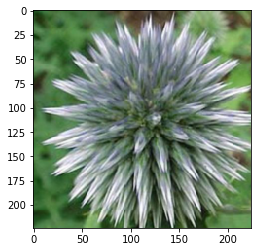

In [12]:
# ------------------ prediction ----
print("--- prediction ---")
top_probs, top_labels, top_flowers = predict( model, param_image_file, param_top_k )

for i in range( len(top_flowers) ):
    # add +1 to index, because cat_to_name starts with index 1 and not with 0
    print(" {} with {:.3f} is {}".format(i+1, top_probs[i], top_flowers[i] ) )
print("------------------")
# ----------------------------------
# show image or plot bar graph, I couldn't found a good solution to display both things at the same time
imshow( process_image(param_image_file) )
#plot_bargraph( top_probs, top_flowers )

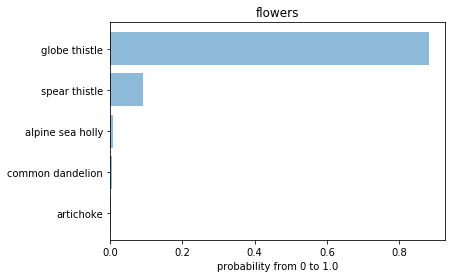

In [13]:
plot_bargraph( top_probs, top_flowers )